# a multi agent example

A multi agent application is one that involves multiple independent actors powered by language models connected in a specific way.

Multi agent can, for instance, be a benefitial pattern if:

- your tool calling LLM has too many tools to select from, so you'd want to split these tools in dedicated agents
- evaluating the efficieny of each layer of your graph application is too complex, so you'd want to split these layers in dedicated agents that can be more easily monitored and updated atomically
- you have trouble thinking of your system as a whole because it's becoming too complex, so you'd want to break it down into more manageable units of work

## focus on a multi agent collaboration example

Multi agent collaboration works by allowing different agents to share a scratchpad of messages, this means that the work of each agent is visible to the other agents.

In this example, we will use a researcher agent and a chart generator agent.

## first, write the tools

In [1]:
from agentic_search.capabilities.web import get_web_search_results
from langchain_core.tools import tool

@tool
async def search_the_web_tool(query: str) -> str:
    """
    Searches the web for a given query using DuckDuckGo search engine.

    Args:
        query (str): The search query string to look up on the web.

    Returns:
        str: The processed search results as a string, containing relevant information
            based on the query.
    """
    res = await get_web_search_results(query)
    return res.content

In [2]:
from langchain_experimental.utilities import PythonREPL
from typing import Annotated

# we need now to define a REPL tool
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## define the agent nodes

In [3]:
# this system prompt will be used by each agent
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools will help where you left off."
        " Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [4]:
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_ollama import ChatOllama
from langgraph.graph import MessagesState, END
from langgraph.prebuilt import create_react_agent
# the `Command` type allows to specify which node to execute next and to directly update the graph state, among other things
from langgraph.types import Command
from typing import Literal

llm = ChatOllama(model="llama3.1")

# logic to get the next node to execute
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # any agent decided the work is done
        return END
    return goto

In [5]:
# writing the research agent and node

research_agent = create_react_agent(
    llm,
    tools=[search_the_web_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [6]:
# writing the chart generator agent and node

chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )

## define the graph

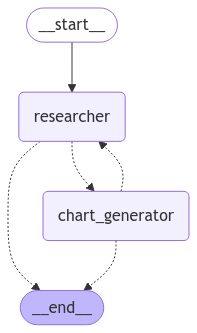

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## let's try it out!

{'researcher': {'messages': [HumanMessage(content='First, get some data points about the evolution of gold price over the past 5 years. Then, make a line chart of it. Once you make the chart, finish.', additional_kwargs={}, response_metadata={}, id='cd35c045-883e-413d-87d8-cd180e210358'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-02-02T19:41:35.11078904Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7987741884, 'load_duration': 15712588, 'prompt_eval_count': 348, 'prompt_eval_duration': 42000000, 'eval_count': 172, 'eval_duration': 7928000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-30f8870d-c1b9-426b-9ad7-55884f84ae67-0', tool_calls=[{'name': 'search_the_web_tool', 'args': {'query': 'gold price evolution over the past 5 years'}, 'id': 'f2da0f13-9312-4377-8f07-179a25f9183f', 'type': 'tool_call'}, {'name': 'chart_generator_tool', 'args': {'data': [[2020, 1500], [2021

Python REPL can execute arbitrary code. Use with caution.


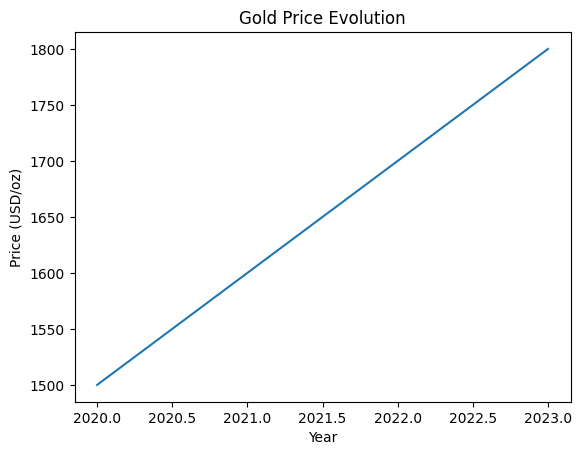

{'chart_generator': {'messages': [HumanMessage(content='First, get some data points about the evolution of gold price over the past 5 years. Then, make a line chart of it. Once you make the chart, finish.', additional_kwargs={}, response_metadata={}, id='cd35c045-883e-413d-87d8-cd180e210358'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-02-02T19:41:35.11078904Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7987741884, 'load_duration': 15712588, 'prompt_eval_count': 348, 'prompt_eval_duration': 42000000, 'eval_count': 172, 'eval_duration': 7928000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-30f8870d-c1b9-426b-9ad7-55884f84ae67-0', tool_calls=[{'name': 'search_the_web_tool', 'args': {'query': 'gold price evolution over the past 5 years'}, 'id': 'f2da0f13-9312-4377-8f07-179a25f9183f', 'type': 'tool_call'}, {'name': 'chart_generator_tool', 'args': {'data': [[2020, 1500], 

In [8]:
events = graph.astream(
    {
        "messages": [
            (
                "user",
                "First, get some data points about the evolution of gold price over the past 5 years. Then, make a line chart of it."
                " Once you make the chart, finish.",
            )
        ],
    },
    {"recursion_limit": 150},
)
async for s in events:
    print(s)
    print("----")